In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

In [44]:
circ_name = r'..\circuits\Arithmetic_and_Toffoli\gf2^6_mult_before'
c = zx.Circuit.load(circ_name).to_basic_gates()
print(c.stats())
g = c.to_graph()
zx.simplify.full_reduce(g)
circuit = zx.extract.streaming_extract(g)
#zx.draw(circuit, figsize=(20,4))

Circuit gf2^6_mult_before on 18 qubits with 617 gates.
        252 T-like gates
        365 Cliffords among which 
        221 2-qubit gates and 144 Hadamard gates.


In [45]:
c2, blocks = circuit_phase_polynomial_blocks(circuit.to_basic_gates(),optimize=True)
print(c2.stats())

Circuit  on 18 qubits with 1063 gates.
        150 T-like gates
        913 Cliffords among which 
        631 2-qubit gates and 270 Hadamard gates.


In [46]:
o = Optimizer(circuit.to_basic_gates())
c = o.parse_circuit()
print(c.stats())
#zx.draw(c, figsize=(30,4))

Circuit  on 18 qubits with 894 gates.
        150 T-like gates
        744 Cliffords among which 
        720 2-qubit gates and 12 Hadamard gates.


In [47]:
for i in range(8):
    c3, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
    print(c3.stats())
    o = Optimizer(c3)
    c = o.parse_circuit()
    print(c.stats())
# print(c4.stats())
# c5, blocks = circuit_phase_polynomial_blocks(c4,optimize=True)
# print(c5.stats())
# o = Optimizer(c5)
# c6 = o.parse_circuit()
# print(c6.stats())

Circuit  on 18 qubits with 876 gates.
        150 T-like gates
        726 Cliffords among which 
        550 2-qubit gates and 164 Hadamard gates.
Circuit  on 18 qubits with 722 gates.
        150 T-like gates
        572 Cliffords among which 
        548 2-qubit gates and 12 Hadamard gates.
Circuit  on 18 qubits with 846 gates.
        150 T-like gates
        696 Cliffords among which 
        535 2-qubit gates and 144 Hadamard gates.
Circuit  on 18 qubits with 706 gates.
        150 T-like gates
        556 Cliffords among which 
        527 2-qubit gates and 12 Hadamard gates.
Circuit  on 18 qubits with 813 gates.
        150 T-like gates
        663 Cliffords among which 
        514 2-qubit gates and 132 Hadamard gates.
Circuit  on 18 qubits with 689 gates.
        150 T-like gates
        539 Cliffords among which 
        510 2-qubit gates and 12 Hadamard gates.
Circuit  on 18 qubits with 793 gates.
        150 T-like gates
        643 Cliffords among which 
        502 2-qub

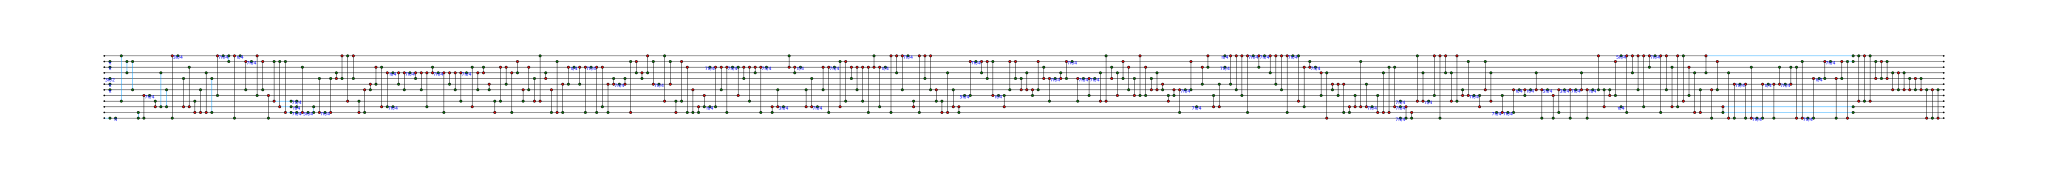

In [42]:
zx.draw(c, figsize=(50,4))

In [21]:
zx.compare_tensors(c, circuit)

True

In [6]:
from pyzx.circuit import Circuit, ZPhase, CNOT, CZ, ParityPhase, NOT, HAD, SWAP
from pyzx.extract import permutation_as_swaps

class Optimizer:
    def __init__(self, circuit):
        self.circuit = circuit
        self.qubits = circuit.qubits
        
    
    def parse_circuit(self):
        self.circuit = self.parse_forward()
        self.circuit.gates = list(reversed(self.circuit.gates))
        self.circuit = self.parse_forward()
        self.circuit.gates = list(reversed(self.circuit.gates))
        self.circuit = self.parse_forward()
        for g in self.circuit.gates: g.index = 0
        return self.circuit
    
    def parse_forward(self):
        self.gates = {i:list() for i in range(self.qubits)}
        self.available = {i:list() for i in range(self.qubits)}
        self.availty = {i: 1 for i in range(self.qubits)}
        self.hadamards = []
        self.permutation = {i:i for i in range(self.qubits)}
        self.gcount = 0
        for g in self.circuit.gates:
            self.parse_gate(g)
        for t in self.hadamards.copy():
            self.add_hadamard(t)
        
        c = Circuit(self.qubits)
        indices = []
        for gs in self.gates.values():
            for g in gs:
                if g.index not in indices:
                    indices.append(g.index)
                    c.gates.append(g)
        c.gates.sort(key = lambda g: g.index)
        swaps = permutation_as_swaps(self.permutation)
        for a,b in swaps:
            c.gates.extend(SWAP(a,b).to_basic_gates())
        return c
    
    def add_hadamard(self, t):
        h = HAD(t)
        h.index = self.gcount
        self.gates[t].append(h)
        self.gcount += 1
        self.hadamards.remove(t)
        self.available[t] = list()
        self.availty[t] = 1
    
    def add_gate(self, t, g):
        g.index = self.gcount
        self.gcount += 1
        self.gates[t].append(g)
        self.available[t].append(g)
    
    def add_cz(self, cz):
        t1, t2 = cz.control, cz.target
        if self.availty[t1] == 2:
            self.available[t1] = list()
            self.availty[t1] = 1
        if self.availty[t2] == 2:
            self.available[t2] = list()
            self.availty[t2] = 1
        found_match = False
        for g in reversed(self.available[t1]):
            if g.name == 'CZ' and g.control == t1 and g.target == t2:
                found_match = True
                break
        if found_match:
            if g not in self.available[t2]:
                found_match = False
            else:
                self.available[t1].remove(g)
                self.gates[t1].remove(g)
                self.available[t2].remove(g)
                self.gates[t2].remove(g)
                self.detect_available(t1)
                self.detect_available(t2)
        if not found_match:
            cz.index = self.gcount
            self.gcount += 1
            self.gates[t1].append(cz)
            self.gates[t2].append(cz)
            self.available[t1].append(cz)
            self.available[t2].append(cz)
    
    def add_cnot(self, cnot):
        c, t = cnot.control, cnot.target
        if self.availty[c] == 2:
            if self.availty[t] == 1: # Try to find anti-match
                found_match = False
                for g in reversed(self.available[c]):
                    if g.name == 'CNOT' and g.control == t and g.target == c:
                        found_match = True
                        break
                if found_match:
                    if g in self.available[t]:
                        self.gates[c].remove(g)
                        self.gates[t].remove(g)
                        self.availty[c] = 1
                        self.availty[t] = 2
                        cnot.index = self.gcount
                        self.gcount += 1
                        self.gates[c].append(cnot)
                        self.gates[t].append(cnot)
                        self.available[c] = [cnot]
                        self.available[t] = [cnot]
                        a = self.permutation[c]
                        b = self.permutation[t]
                        self.permutation[c] = b
                        self.permutation[t] = a
                        if t in self.hadamards and not c in self.hadamards:
                            self.hadamards.remove(t)
                            self.hadamards.append(c)
                        elif c in self.hadamards and not t in self.hadamards:
                            self.hadamards.remove(c)
                            self.hadamards.append(t)
                        return
                
            self.available[c] = list()
            self.availty[c] = 1
        if self.availty[t] == 1:
            self.available[t] = list()
            self.availty[t] = 2
        found_match = False
        for g in reversed(self.available[c]):
            if g.name == 'CNOT' and g.control == c and g.target == t:
                found_match = True
                break
        if found_match:
            if g not in self.available[t]:
                found_match = False
            else:
                self.available[c].remove(g)
                self.gates[c].remove(g)
                self.available[t].remove(g)
                self.gates[t].remove(g)
                self.detect_available(c)
                self.detect_available(t)
                
        if not found_match:
            cnot.index = self.gcount
            self.gcount += 1
            self.gates[c].append(cnot)
            self.gates[t].append(cnot)
            self.available[c].append(cnot)
            self.available[t].append(cnot)
    
    def detect_available(self, t):
        pass
    
    def parse_gate(self, g):
        g = g.copy()
        g.target = next(i for i in self.permutation if self.permutation[i] == g.target)
        if g.name in ('CZ', 'CNOT'):
            g.control = next(i for i in self.permutation if self.permutation[i] == g.control)
        if g.name == 'HAD':
            if g.target in self.hadamards:
                self.hadamards.remove(g.target)
            else:
                self.hadamards.append(g.target)
        elif isinstance(g, ZPhase):
            t = g.target
            if t in self.hadamards:
                self.add_hadamard(t)
            if self.availty[t] == 1 and any(isinstance(g2, ZPhase) for g2 in self.available[t]):
                i = next(i for i,g2 in enumerate(self.available[t]) if isinstance(g2, ZPhase))
                g2 = self.available[t].pop(i)
                p = ZPhase(t, g.phase+g2.phase)
                self.add_gate(t,p)
            else:
                if self.availty[t] == 2:
                    self.availty[t] = 1
                    self.available[t] = list()
                self.add_gate(t, g)
        elif g.name == 'CZ':
            t1, t2 = g.control, g.target
            if t1 > t2:
                g.target = t1
                g.control = t2
            if t1 in self.hadamards and t2 in self.hadamards:
                self.add_hadamard(t1)
                self.add_hadamard(t2)
            if t1 not in self.hadamards and t2 not in self.hadamards:
                self.add_cz(g)
            # Exactly one of t1 and t2 has a hadamard
            elif t1 in self.hadamards:
                cnot = CNOT(t2, t1)
                self.add_cnot(cnot)
            else:
                cnot = CNOT(t1, t2)
                self.add_cnot(cnot)
            
        elif g.name == 'CNOT':
            c, t = g.control, g.target
            if c in self.hadamards and t in self.hadamards:
                g.control = t
                g.target = c
                self.add_cnot(g)
            elif c not in self.hadamards and t not in self.hadamards:
                self.add_cnot(g)
            elif t in self.hadamards:
                cz = CZ(c if c<t else t, c if c>t else t)
                self.add_cz(cz)
            else: # Only the control has a hadamard gate in front of it
                self.add_hadamard(c)
                self.add_cnot(g)

In [20]:
a = CNOT(5,3)
c, t = a.control, a.target
# a.index = 1
# b = CZ(1,2)
# b.index = 2
# a in [a]
cz = CZ(c if c<t else t, c if c>t else t)
cz

CZ(3,5)